# Modelling Bernoulli Mixture Models with Dirichlet Processes

I've been spending a lot of time over the last week ~~getting Theano working on Windows~~ playing with Dirichlet Processes for clustering binary data using `PyMC3`. While there is a great [tutorial for mixtures of univariate distributions](https://docs.pymc.io/notebooks/dp_mix.html), there isn't a lot out there for multivariate mixtures, and Bernoulli mixtures in particular.

This notebook shows an example using both NUTS and Variational Inference to fit the parameters.

Let's firstly setup the environment and create a simulated dataset of 1000 observations of 5 binary variables, belonging to 3 groups with different rates.

## Simulated dataset

In [42]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

N = 1000
P = 5

# Simulate 5 variables with 1000 observations of each that fit into 3 groups
mu_actual = np.array([[0.7, 0.8, 0.2, 0.1, 0.1],
                      [0.3, 0.5, 0.9, 0.8, 0.6],
                      [0.1, 0.2, 0.5, 0.4, 0.9]])
cluster_ratios = [0.4, 0.3, 0.3]  

df = np.concatenate([np.random.binomial(1, mu_actual[0, :], size=(int(N*cluster_ratios[0]), P)),
                     np.random.binomial(1, mu_actual[1, :], size=(int(N*cluster_ratios[1]), P)),
                     np.random.binomial(1, mu_actual[2, :], size=(int(N*cluster_ratios[2]), P))])
df[1:10, :]

array([[1, 0, 0, 1, 0],
       [1, 1, 0, 0, 0],
       [1, 0, 0, 1, 0],
       [1, 1, 1, 1, 0],
       [1, 1, 0, 0, 1],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [1, 1, 0, 0, 0],
       [0, 1, 0, 0, 0]])

In [6]:
df.shape

(1000, 5)

## Mixture model specification

Now let's setup the Dirichlet Process, firstly importing Theano and PyMC3.

In [7]:
from theano import tensor as tt
import pymc3 as pm

As in the above tutorial, we'll be using the stick-breaking method (Sethuraman 1994) to perform draws from G.

In [9]:
# Deterministic function for stick breaking
def stick_breaking(beta):
    portion_remaining = tt.concatenate([[1], tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * portion_remaining

The following snippet defines the model, which is a fairly simple model to complete the prior on G, as well as providing a prior on the Bernoulli parameters $\mu$.

Note the definition of $K=30$. This isn't forcing a finite mixture model with 30 clusters, but rather it is an approximation $K\to\infty$, due to the stick-breaking method it doesn't matter how big it is provided it is much bigger than the expected number of clusters, which can be given by apriori knowledge of the data and $\alpha\log(N)$.

The next lines deal with the mixture model itself, using the `Mixture` distribution provided in `PyMC3`. Getting this to work with multivariate distributions requires careful setting of the shapes, ensuring that the last dimension of the mixture distributions is the cluster that is being mixed over.

Also note the hack to get this working with 2D observations pointed out by [lucianopaz on my dicourse issue](https://discourse.pymc.io/t/mixture-of-multivariate-bernoullis/2611/2), by adding an additional dimension.

In [10]:
K = 30

with pm.Model() as model:
    # The DP priors to obtain w, the cluster weights
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    # Prior on Bernoulli parameters, use Jeffrey's conjugate-prior
    mu = pm.Beta('mu', 0.5, 0.5, shape=(P, K))

    obs = pm.Mixture('obs', w, 
                     pm.Bernoulli.dist(mu, shape=(P, K)),
                     shape=(P,1),
                     observed=np.expand_dims(df, axis=2))  # Add 3rd dimension to observations, required for 2D mixture

Let's sample from this with NUTS under the default settings. Note how long it takes to converge.

In [11]:
with model:
    trace = pm.sample(random_seed=17)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [25:30<00:00,  1.34s/draws]
There were 232 divergences after tuning. Increase `target_accept` or reparameterize.
There were 277 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


The convergence looks ok, and there weren't many errors thrown up before. 

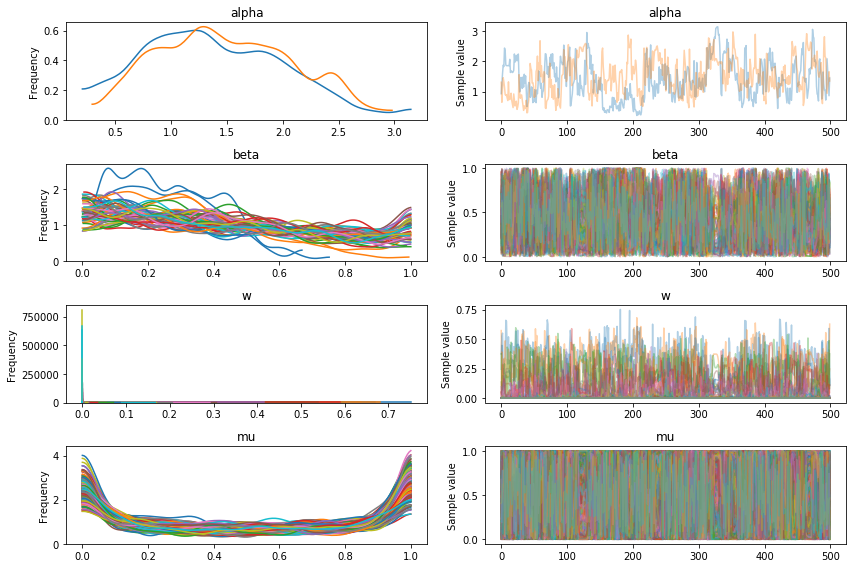

In [14]:
pm.traceplot(trace)
plt.show()

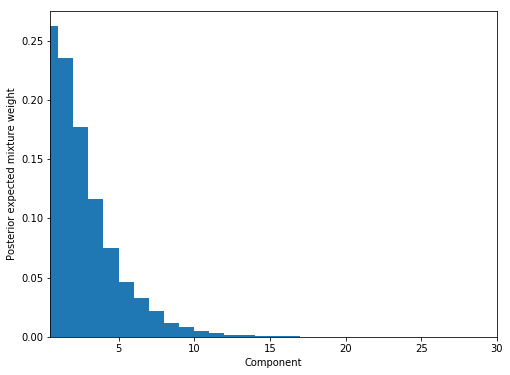

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1
ax.bar(plot_w - 0.5, trace['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, K);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

plt.show()

## Manually calculating likelihood

In [20]:
def bernoulli_loglh(mus, weights):
    def _logp(value):
        value_neg = 1 - value
        logmus = tt.log(mus)
        neglogmus = tt.log(1-mus)

        # N*K matrix of likelihood contributions from X_i with mu_k
        betas = tt.tensordot(value, logmus, axes=[1, 1]) + tt.tensordot(value_neg, neglogmus, axes=[1, 1])

        ## Form alphas, NxK matrix with the component weights included
        alphas = (betas + tt.log(weights)).T

        # Take LSE rowise to get N vector
        # and add alpha_cluster1 to get the total likelihood across all
        # components for each X_i
        lse_clust = pm.math.logsumexp(alphas - alphas[0, :], axis=0) + alphas[0,:]

        # Final overall sum
        return tt.sum(lse_clust)
    return _logp

In [21]:
with pm.Model() as model:
    # The DP priors to obtain w, the cluster weights
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1, alpha, shape=K)
    w = pm.Deterministic('w', stick_breaking(beta))

    mu = pm.Beta('mu', 1, 1, shape=(K, P))
    obs = pm.DensityDist('obs', bernoulli_loglh(mu, w),
                         observed=df)

Notice how much quicker this is! However, there are still divergences, there is high Gelman-Rubin, and the number of components hasn't reached 3 yet.

In [22]:
with model:
    trace2 = pm.sample(random_seed=17)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, beta, alpha]
Sampling 2 chains: 100%|██████████| 2000/2000 [04:32<00:00,  7.34draws/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7036998165465314, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


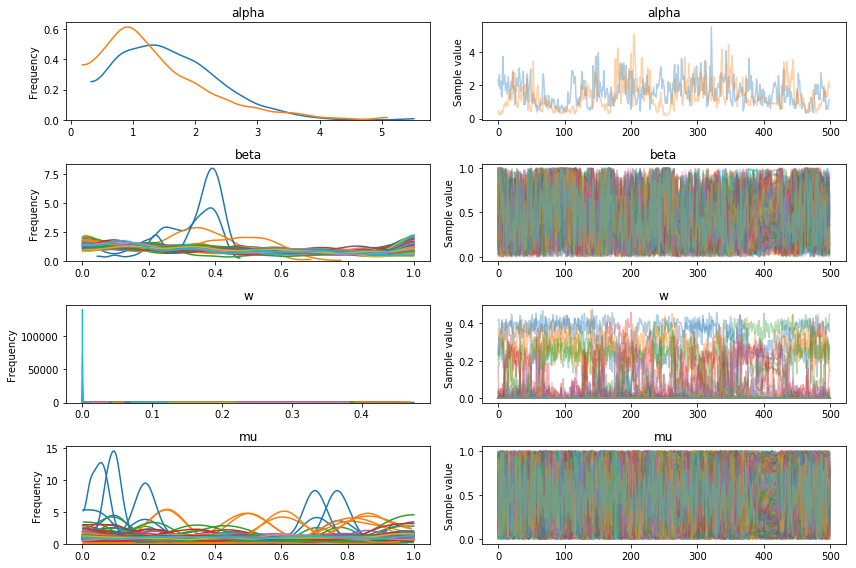

In [23]:
pm.traceplot(trace2)
plt.show()

But, due to the quicker sampling we can take more samples and increase the tuning length and raise the target acceptance rate as suggested in the log above.


In [25]:
with model:
    trace3 = pm.sample(10000, 
                      random_seed=17, 
                      tune=1000,
                      nuts_kwargs={'target_accept': 0.9})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, beta, alpha]
Sampling 2 chains: 100%|██████████| 22000/22000 [46:23<00:00,  5.99draws/s] 
There were 199 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.785823237701799, but should be close to 0.9. Try to increase the number of tuning steps.
There were 34 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


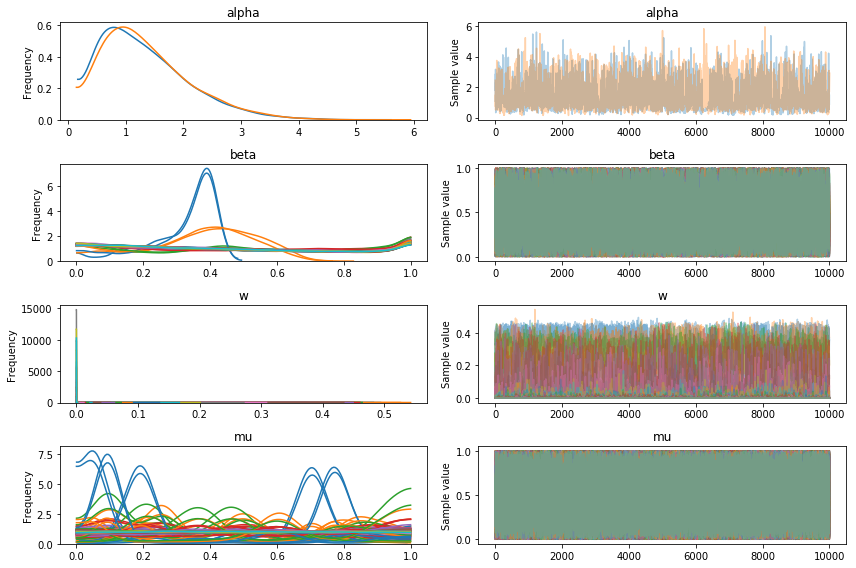

In [26]:
pm.traceplot(trace3)
plt.show()

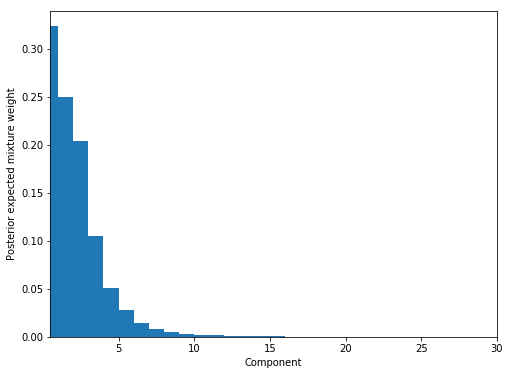

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1
ax.bar(plot_w - 0.5, trace3['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, K);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

plt.show()

In [49]:
mean_w = np.mean(trace3['w'], axis=0)
nonzero_component = np.where(mean_w > 0.1)[0]
mean_mu = np.mean(trace3['mu'], axis=0)
print(mean_mu[nonzero_component, :])

Mu of nonzero components
[[0.69827809 0.76301106 0.19907415 0.09943633 0.06208112]
 [0.10971211 0.2163405  0.45631529 0.36027125 0.93148039]
 [0.27003523 0.5033192  0.85294047 0.8071149  0.58824517]]


## Variational Inference

In [40]:
with model:
    vi_fit = pm.fit(method='advi')
trace4 = vi_fit.sample()

Average Loss = 3,286: 100%|██████████| 10000/10000 [00:31<00:00, 321.36it/s] 
Finished [100%]: Average Loss = 3,285.6


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f73496be358>,
      dtype=object)

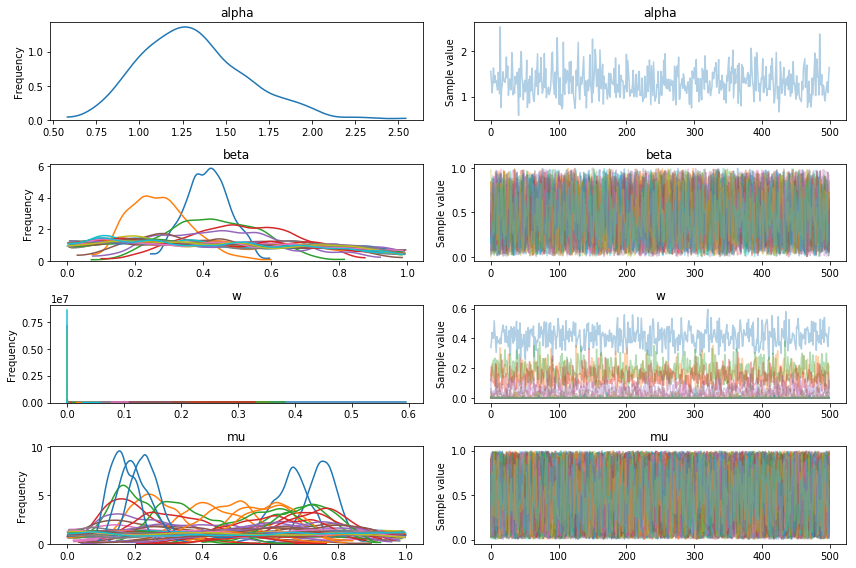

In [43]:
pm.traceplot(trace4)

Given how quickly this ran, let's give it a bit longer to fit and increase the number of drawn samples although no real benefits after 30,000 iterations.

In [44]:
with model:
    vi_fit = pm.fit(method='advi', n=100000)
trace5 = vi_fit.sample(10000)

Average Loss = 3,191.5: 100%|██████████| 100000/100000 [05:19<00:00, 312.61it/s]
Finished [100%]: Average Loss = 3,191.5


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7334273b70>,
      dtype=object)

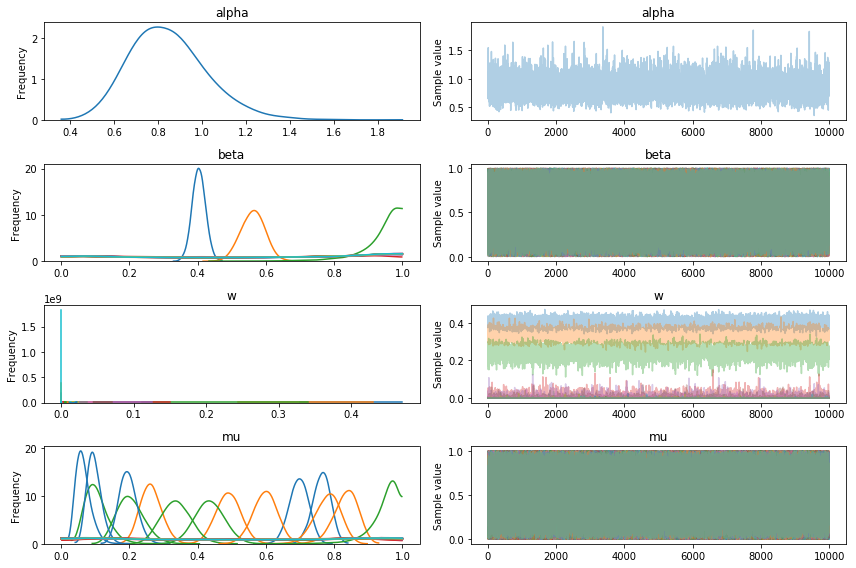

In [45]:
pm.traceplot(trace5)

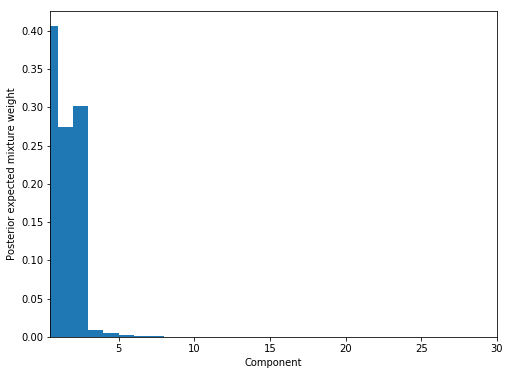

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(K) + 1
ax.bar(plot_w - 0.5, trace5['w'].mean(axis=0), width=1., lw=0);
ax.set_xlim(0.5, K);
ax.set_xlabel('Component');
ax.set_ylabel('Posterior expected mixture weight');

plt.show()

In [47]:
mean_w = np.mean(trace5['w'], axis=0)
nonzero_component = np.where(mean_w > 0.1)[0]

mean_mu = np.mean(trace5['mu'], axis=0)
print(mean_mu[nonzero_component, :])

mean w
~~~~~
[4.06269051e-01 2.74507430e-01 3.01292929e-01 9.01917238e-03
 4.58924407e-03 2.28640735e-03 1.06699717e-03 5.08046672e-04
 2.43610908e-04 1.12869869e-04 5.31437472e-05 2.69979376e-05
 1.37467403e-05 5.14803374e-06 2.57326466e-06 1.54524523e-06
 6.09142145e-07 2.58560886e-07 1.19840159e-07 5.14835179e-08
 2.35260530e-08 1.12865767e-08 8.69385509e-09 2.10790967e-09
 7.87419856e-10 5.94736039e-10 1.64777922e-10 7.97340601e-11
 6.76979486e-11 1.85411837e-11]
Mu of nonzero components
~~~~~
[[0.69827809 0.76301106 0.19907415 0.09943633 0.06208112]
 [0.10971211 0.2163405  0.45631529 0.36027125 0.93148039]
 [0.27003523 0.5033192  0.85294047 0.8071149  0.58824517]]


In [39]:
mu_actual

array([[0.7, 0.8, 0.2, 0.1, 0.1],
       [0.3, 0.5, 0.9, 0.8, 0.6],
       [0.1, 0.2, 0.5, 0.4, 0.9]])